<a href="https://colab.research.google.com/github/forza-panino/anomaly_detection/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q gwpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import random
import torch
import numpy as np
from google.colab import drive
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import os
from typing import Callable, Sequence, Union, Optional
import torchvision.transforms as transforms
import json
import requests
import torch.nn as nn
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import torchvision
from datetime import datetime
from sklearn import metrics
import gc

In [ ]:
seed = 42

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

g = torch.Generator()
g.manual_seed(seed)

tg = torch.Generator()
tg.manual_seed(seed)

pg = torch.Generator()
pg.manual_seed(seed)


tmp_g = torch.Generator()
tmp_g.manual_seed(424242424242)
tg_test_state = tmp_g.get_state()

random.seed(seed)
rand_inst = random.Random(seed)
np.random.seed(seed)

torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

## Data loader

In [ ]:
%%capture
drive.mount('/content/drive', force_remount=True)

In [ ]:
class CanopiesDataset(Dataset):
    def __init__(
        self,
        image_names: Sequence[str],
        transform: Optional[Callable] = None,
    ) -> None:
        """
        `image_names`: sequence of paths to images.
        `transform`: callable to transform the images.
        """
        self.image_names = image_names
        self.transform = transform

    def __len__(self) -> int:
        """
        Returns the number of images in the dataset.
        """
        return len(self.image_names)

    def __getitem__(
        self,
        idx: int,
    ) -> Union[tuple[np.ndarray, np.ndarray], tuple[torch.Tensor, torch.Tensor]]:
        """
        Returns a tuple of the image and the image itself.

        `idx`: index of the image.
        """
        image = np.array(Image.open(self.image_names[idx]).convert("RGB"))

        if self.transform:
            image = self.transform(image)

        return image, image


def get_loaders(
    data_dir: str,
    batch_size: int,
    train_percentage: float = 0.8,
    val_percentage: float = 0.1,
    train_limit: Optional[int] = None,
    transform: Optional[Callable] = None,
    num_workers: int = 0,
) -> tuple[DataLoader, DataLoader, DataLoader, DataLoader]:
    """
    Returns the train, validation and test data loaders for the good crops
    and the test data loader for the bad crops.

    `data_dir`: path to the directory containing the `good` and `bad` directories.
    `batch_size`: the batch size to use for the data loaders.
    `train_percentage`: the percentage of the good data to use for training.
    `val_percentage`: the percentage of the good data to use for validation.
    `train_limit`: the maximum number of images to use for training.
    `transform`: the transform to apply to the images.
    `num_workers`: the number of workers to use for the data loaders.
    """
    good_dir = os.path.join(data_dir, "good")
    good_dir_1 = os.path.join(good_dir, "scale_1")
    good_dir_1_5 = os.path.join(good_dir, "scale_1.5")
    good_dir_2 = os.path.join(good_dir, "scale_2")

    good_images = (
        [
            os.path.join(good_dir_1, image_name)
            for image_name in os.listdir(good_dir_1)
            if image_name.endswith(".jpg")
        ]
        + [
            os.path.join(good_dir_1_5, image_name)
            for image_name in os.listdir(good_dir_1_5)
            if image_name.endswith(".jpg")
        ]
        + [
            os.path.join(good_dir_2, image_name)
            for image_name in os.listdir(good_dir_2)
            if image_name.endswith(".jpg")
        ]
    )

    random.seed(seed)              #######################
    rand_inst = random.Random(seed)#######################
    np.random.seed(seed)           #######################
    torch.manual_seed(seed)        #######################
    torch.cuda.manual_seed(seed)   #######################
    torch.cuda.manual_seed_all(seed)######################
    rand_inst.shuffle(good_images) #######################

    train_images = good_images[: int(len(good_images) * train_percentage)]
    if train_limit is not None:
        train_images = train_images[:train_limit]

    val_images = good_images[
        int(len(good_images) * train_percentage) : int(
            len(good_images) * (train_percentage + val_percentage)
        )
    ]
    test_images_good = good_images[
        int(len(good_images) * (train_percentage + val_percentage)) :
    ]

    bad_dir = os.path.join(data_dir, "bad")
    bad_dir_1 = os.path.join(bad_dir, "scale_1")
    bad_dir_1_5 = os.path.join(bad_dir, "scale_1.5")
    bad_dir_2 = os.path.join(bad_dir, "scale_2")

    test_images_bad = (
        [
            os.path.join(bad_dir_1, image_name)
            for image_name in os.listdir(bad_dir_1)
            if image_name.endswith(".jpg")
        ]
        + [
            os.path.join(bad_dir_1_5, image_name)
            for image_name in os.listdir(bad_dir_1_5)
            if image_name.endswith(".jpg")
        ]
        + [
            os.path.join(bad_dir_2, image_name)
            for image_name in os.listdir(bad_dir_2)
            if image_name.endswith(".jpg")
        ]
    )

    random.seed(seed)                  #######################
    rand_inst = random.Random(seed)    #######################
    np.random.seed(seed)               #######################
    torch.manual_seed(seed)            #######################
    torch.cuda.manual_seed(seed)       #######################
    torch.cuda.manual_seed_all(seed)   #######################
    rand_inst.shuffle(test_images_bad) #######################

    train_dataset = CanopiesDataset(
        image_names=train_images,
        transform=transform,
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        generator=g
    )

    validation_dataset = CanopiesDataset(
        image_names=val_images,
        transform=transform,
    )

    val_loader = DataLoader(
        validation_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        generator=g
    )

    test_good_dataset = CanopiesDataset(
        image_names=test_images_good,
        transform=transform,
    )

    test_good_loader = DataLoader(
        test_good_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        generator=pg
    )

    test_bad_dataset = CanopiesDataset(
        image_names=test_images_bad,
        transform=transform,
    )

    test_bad_loader = DataLoader(
        test_bad_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        generator=pg
    )

    return train_loader, val_loader, test_good_loader, test_bad_loader

## EfficientNet

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


## Decoder

In [ ]:
class MyDecoder(nn.Module):

    def __init__(self, input_channels=3, output_channels=1,
                 features=[16, 32, 64, 128, 256]):
        super(MyDecoder, self).__init__()

        self.ups = nn.ModuleList()
        self.features = features
        self.downsampling = nn.Conv2d(input_channels, features[-1]*2, kernel_size=1).to(device)
        self.output_channels = output_channels
        self.channels_stacking = nn.ModuleList()
        self.upsr = nn.ModuleList()
        self.upsg = nn.ModuleList()
        self.upsb = nn.ModuleList()

        # Decoder
        for f in reversed(features):
            self.upsr.append(
                nn.Sequential(
                    nn.Upsample(scale_factor=2),
                    nn.Conv2d(in_channels=2 * f, out_channels=f, kernel_size=3,
                              padding=1),
                    nn.BatchNorm2d(f),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(in_channels=f, out_channels=f, kernel_size=15,
                              padding=7),
                    nn.BatchNorm2d(f),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(in_channels=f, out_channels=f, kernel_size=9,
                              padding=4),
                    nn.BatchNorm2d(f),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(in_channels=f, out_channels=f, kernel_size=3,
                              padding=1),
                    nn.BatchNorm2d(f),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(in_channels=f, out_channels=f, kernel_size=1,
                              padding=0),
                    nn.BatchNorm2d(f),
                    nn.ReLU(inplace=True)
                )
            )
            self.upsg.append(
                nn.Sequential(
                    nn.Upsample(scale_factor=2),
                    nn.Conv2d(in_channels=2 * f, out_channels=f, kernel_size=3,
                              padding=1),
                    nn.BatchNorm2d(f),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(in_channels=f, out_channels=f, kernel_size=15,
                              padding=7),
                    nn.BatchNorm2d(f),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(in_channels=f, out_channels=f, kernel_size=9,
                              padding=4),
                    nn.BatchNorm2d(f),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(in_channels=f, out_channels=f, kernel_size=3,
                              padding=1),
                    nn.BatchNorm2d(f),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(in_channels=f, out_channels=f, kernel_size=1,
                              padding=0),
                    nn.BatchNorm2d(f),
                    nn.ReLU(inplace=True)
                )
            )
            self.upsb.append(
                nn.Sequential(
                    nn.Upsample(scale_factor=2),
                    nn.Conv2d(in_channels=2 * f, out_channels=f, kernel_size=3,
                              padding=1),
                    nn.BatchNorm2d(f),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(in_channels=f, out_channels=f, kernel_size=15,
                              padding=7),
                    nn.BatchNorm2d(f),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(in_channels=f, out_channels=f, kernel_size=9,
                              padding=4),
                    nn.BatchNorm2d(f),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(in_channels=f, out_channels=f, kernel_size=3,
                              padding=1),
                    nn.BatchNorm2d(f),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(in_channels=f, out_channels=f, kernel_size=1,
                              padding=0),
                    nn.BatchNorm2d(f),
                    nn.ReLU(inplace=True)
                )
            )
            self.channels_stacking.append(
                nn.Sequential(
                    nn.Conv2d(in_channels=3 * f, out_channels=f, kernel_size=3,
                              padding=1),
                    nn.BatchNorm2d(f),
                    nn.ReLU(inplace=True)
                )
            )

        self.final_convolution = nn.Conv2d(in_channels=features[0],
                                           out_channels=output_channels,
                                           kernel_size=3, padding=1).to(device)

    def forward(self, x):

        x = self.downsampling(x)

        for i in range(0, len(self.upsr)):
            xr = self.upsr[i](x)
            xg = self.upsg[i](x)
            xb = self.upsb[i](x)
            x = self.channels_stacking[i](torch.cat((xr, xg, xb), 1))

        x = self.final_convolution(x)

        return x

#### Function to do weight initialization

In [ ]:
def decoder_weight_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        elif name.startswith("channels_stacking") or name.startswith("ups") or name.startswith("final_convolution"):
            if len(param.shape) == 1: ### batchnorm2d weight or bias
              if name.endswith(".bias"):
                param.data.fill_(0)
              elif name.endswith(".weight"):
                param.data.fill_(1) ### batchnorm2d init
              else:
                raise Exception(f"Unhadled sub-layer: {name}")
            else: # Do have ReLu applied on input, we apply Kaiming
              torch.nn.init.kaiming_uniform_(param)
        else:
          raise Exception(f"Unhandled layer: {name}")

## Concatenation

In [ ]:
class AutoEncoder(torch.nn.Module):

    def __init__(self, decoder, encoder):
        super(AutoEncoder, self).__init__()
        self.decoder = decoder
        self.encoder = encoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Loss function definition

In [ ]:
%%capture
!git clone https://github.com/Po-Hsun-Su/pytorch-ssim.git

In [ ]:
%%capture
!cp -r pytorch-ssim/pytorch_ssim/ pytorch_ssim

In [ ]:
from pytorch_ssim import SSIM

In [ ]:
%%capture
#!pip install piqa

In [ ]:
#from piqa import SSIM

In [ ]:
class SSIMLoss(SSIM):
    def forward(self, x, y):
        return 1. - super().forward(x, y)

In [ ]:
loss_fn = None

## Train

### Early stop criterion

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0, prev_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.prev_delta = prev_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0

        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            print(f"Exceeding delta from minimum validation loss. Patience now {self.counter}/{self.patience}")

        else:
            self.counter = 0

        if self.counter >= self.patience:
            print("Patience exceeded. Stopping because of diverging validation loss")
            return True

        self.prev_validation_loss = validation_loss
        return False

#### Function definition

In [ ]:
# define the train function
def train(model, train_loader, val_loader, loss_fn, optimizer, num_epochs, lr_scheduler, early_stopper, train_losses_ret, val_losses_ret):
    for epoch in range(num_epochs):
        model.train()
        train_losses = list()
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = loss_fn(outputs, targets)
            loss.backward()

            optimizer.step()

            train_losses.append(loss.item())

        model.eval()
        val_losses = list()
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            loss = loss_fn(outputs, targets)

            val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        print(f"[{epoch + 1}/{num_epochs}] train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}")
        train_losses_ret.append(train_loss)
        val_losses_ret.append(val_loss)

        lr_scheduler.step(val_loss)

        if ((epoch % 3) == 0):
          torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, "drive/MyDrive/tesi/saved_models/checkpoint")

        if early_stopper.early_stop(val_loss):
          return

In [ ]:
def test(model, loss, dataset_type, count_show=10):

  if dataset_type != 'good' and dataset_type != 'bad':
    print("Error in passed type")
    return None

  losses = []

  i = 0
  for imgs, _ in (test_good_loader if dataset_type == 'good' else test_bad_loader):
    for img in imgs:
      img = img.unsqueeze(0).to(device)

      # run the model
      with torch.no_grad():
        out = model(img)

      losses.append(loss(img, out).item())

      # show the result
      out = out.squeeze().detach().cpu().numpy()

      if i < count_show:
        plt.imshow(out.T)
        plt.show()
        i += 1

  return losses


#### Configurations & Data Loading

In [ ]:
'''
checkpoint = torch.load("drive/MyDrive/tesi/saved_models/checkpoint")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
'''

num_epochs = 50
#num_epochs = 50 - epoch
batch_dimension = 4
limit = None
#limit = 1
tr_prct = 0.8
val_prct = 0.1
wrkrs = 0

In [ ]:
class SaltPepper(object):

    def __init__(self, gen, prob=0.0005):
        self.gen = gen
        self.prob = prob

    def __call__(self, img):
        # pepper
        mask = torch.rand(img.shape, generator=self.gen) < self.prob
        #mask = mask.to(device)
        img[mask] = 0

        # salt
        mask = torch.rand(img.shape, generator=self.gen) < self.prob
        #mask = mask.to(device)
        img[mask] = 1

        return img

    def __repr__(self):
        return self.__class__.__name__+'()'

In [ ]:
if device:
  loss_fn = SSIMLoss().cuda()
  #loss_fn = nn.MSELoss().cuda()
else:
  loss_fn = SSIMLoss()
  #loss_fn = nn.MSELoss()

#### Train & Save

In [ ]:
def genName(es=num_epochs, n_limit=limit):
  name = str(datetime.now()).split(" ")[0].replace('-', '_')
  name += "___"
  name += f"tmp_NEW_IMPL___b{batch_dimension}_e{es}_l{n_limit}"
  loss_fn_name = "mse" if isinstance(loss_fn, nn.MSELoss) else "ssim"
  name += f"_{loss_fn_name}"
  name += "_saltpepper-0-0005_th0-01"
  return name

In [ ]:
samples = [100, 200, 300, 400, 500, 600, 700, 788]
val_curve_losses = []
train_curve_losses = []
auc_scores = []
l_curves_epochs = 25

for sample in samples:

  print(f"########## TRAINING WITH LIMIT: {sample}")
  print("")

  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  g = torch.Generator()
  g.manual_seed(seed)
  tg = torch.Generator()
  tg.manual_seed(seed)
  pg = torch.Generator()
  pg.manual_seed(seed)

  sp_transform = SaltPepper(tg)

  tmp_g = torch.Generator()
  tmp_g.manual_seed(42424242)
  tg_test_state = tmp_g.get_state()

  random.seed(seed)
  rand_inst = random.Random(seed)
  np.random.seed(seed)

  val_losses = []
  train_losses = []

  efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b4', pretrained=True)
  #utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')
  efficientnet.eval().to(device)
  efficientnet.classifier = torch.nn.Identity()
  for param in efficientnet.parameters():
    param.requires_grad = False
  for param in efficientnet.features[-3:-1].parameters():
    param.requires_grad = True
  efficientnet = efficientnet.eval().to(device)

  decoder = MyDecoder(input_channels=1792, output_channels=3)
  #decoder_weight_init(decoder)
  decoder.eval().to(device)
  model = AutoEncoder(decoder, efficientnet)
  model.eval().to(device)

  early_stopper = EarlyStopper(patience=5, min_delta=0.03, prev_delta=0.005)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, threshold=0.1, verbose=True)

  transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((512, 512), antialias=True),
        sp_transform
    ]
  )

  train_loader, val_loader, test_good_loader, test_bad_loader = get_loaders(
        data_dir='drive/MyDrive/tesi/first_dataset',
        batch_size=batch_dimension,
        train_percentage=tr_prct,
        val_percentage=val_prct,
        transform=transform,
        num_workers=wrkrs,
        train_limit=sample,
  )

  root = f"drive/MyDrive/tesi/saved_models/"
  sub = f"{genName(l_curves_epochs, sample)}"
  path = os.path.join(root, sub)
  os.mkdir(path)

  print("")
  train(model, train_loader, val_loader, loss_fn, optimizer, l_curves_epochs, lr_scheduler, early_stopper, train_losses, val_losses)
  print("")


  torch.save(model, f"drive/MyDrive/tesi/saved_models/{sub}/{sub}.pth")

  val_curve_losses.append(val_losses[-1])
  train_curve_losses.append(train_losses[-1])

  tg.set_state(tg_test_state)

  yg_preds = test(model, loss_fn, 'good', count_show=0)
  yb_preds = test(model, loss_fn, 'bad', count_show=0)
  y_preds = yg_preds + yb_preds
  y_true = [0 for _ in yg_preds] + [1 for _ in yb_preds]
  fpr, tpr, thresholds = metrics.roc_curve(y_true, y_preds)
  auc_scores.append(metrics.auc(fpr, tpr))

  with open(f"drive/MyDrive/tesi/saved_models/{sub}/{sample}-data.txt", "w+") as out:
    out.write(f"train_loss: {val_curve_losses[-1]}\n")
    out.write(f"val_loss: {train_curve_losses[-1]}\n")
    out.write(f"auc-score: {auc_scores[-1]}\n")

  del train_loader, val_loader, test_good_loader, test_bad_loader, sp_transform, transform
  torch.cuda.empty_cache()
  gc.collect()


In [ ]:
'''
# loading saved data

samples = [100, 200, 300, 400, 500, 600, 700, 788]

train_curve_losses = [
  0.21284086227416993,
  0.20843875050544738,
  0.19557060400644938,
  0.19722350776195527,
  0.19454551458358765,
  0.1944859218597412,
  0.1884,
  0.19154806851130451
]


val_curve_losses = [
  0.24450950384140013,
  0.4132648372650147,
  0.22638381719589235,
  0.21814579486846924,
  0.2078574800491333,
  0.21144773960113525,
  0.1999,
  0.20590601205825806
]


auc_scores = [
  0.8230021393560266,
  0.6455709914154955,
  0.8173964849568066,
  0.81891299049476,
  0.83467381590706,
  0.8279578628104096,
  0.8222438865870502,
  0.8264684377284912
]

'''

<Figure size 640x480 with 0 Axes>

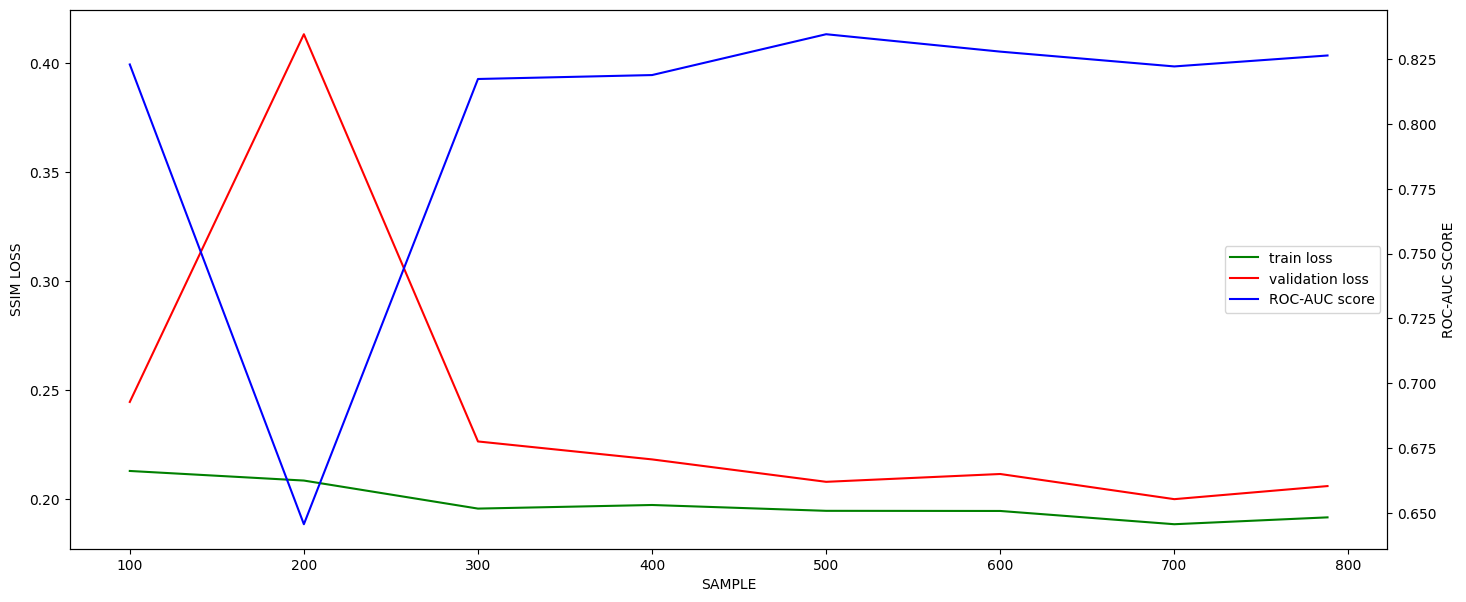

"\nplt.clf()\nplt.gcf().set_size_inches(17, 7)\nplt.xticks(samples)\nplt.plot(samples, train_curve_losses, label='train loss', color='green')\nplt.plot(samples, val_curve_losses, label='validation loss', color='red')\nplt.plot(samples, auc_scores, label='ROC-AUC score', color='blue')\n\n\nplt.legend(loc='best')\nplt.show()\n"

In [ ]:
plt.clf()

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
lines1 = ax1.plot(samples, train_curve_losses, label='train loss', color='green')
lines2 = ax1.plot(samples, val_curve_losses, label='validation loss', color='red')
lines3 = ax2.plot(samples, auc_scores, label='ROC-AUC score', color='blue')

ax1.set_xlabel('SAMPLE')
ax1.set_ylabel('SSIM LOSS')
ax2.set_ylabel('ROC-AUC SCORE')

lines = lines1 + lines2 + lines3
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='center right')

plt.gcf().set_size_inches(17, 7)
plt.show()

'''
plt.clf()
plt.gcf().set_size_inches(17, 7)
plt.xticks(samples)
plt.plot(samples, train_curve_losses, label='train loss', color='green')
plt.plot(samples, val_curve_losses, label='validation loss', color='red')
plt.plot(samples, auc_scores, label='ROC-AUC score', color='blue')


plt.legend(loc='best')
plt.show()
'''

## Analysing results

#### Loading model

In [ ]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

g = torch.Generator()
g.manual_seed(seed)
tg = torch.Generator()
tg.manual_seed(seed)
pg = torch.Generator()
pg.manual_seed(seed)

sp_transform = SaltPepper(tg)

tmp_g = torch.Generator()
tmp_g.manual_seed(42424242)
tg_test_state = tmp_g.get_state()

random.seed(seed)
rand_inst = random.Random(seed)
np.random.seed(seed)

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((512, 512), antialias=True),
        sp_transform
    ]
)

train_loader, val_loader, test_good_loader, test_bad_loader = get_loaders(
        data_dir='drive/MyDrive/tesi/first_dataset',
        batch_size=batch_dimension,
        train_percentage=tr_prct,
        val_percentage=val_prct,
        transform=transform,
        num_workers=wrkrs,
        train_limit=limit,
)

In [ ]:
'''
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b4', pretrained=True)
efficientnet.eval().to(device)
efficientnet.classifier = torch.nn.Identity()
for param in efficientnet.parameters():
  param.requires_grad = False
for param in efficientnet.features[-3:-1].parameters():
  param.requires_grad = True
efficientnet = efficientnet.eval().to(device)

decoder = MyDecoder(input_channels=1792, output_channels=3)
decoder.eval().to(device)
model = AutoEncoder(decoder, efficientnet)
model.eval().to(device)



model = torch.load("drive/MyDrive/tesi/saved_models/2023_08_09___NEW_IMPL___b4_e25_l500_ssim_saltpepper-0-0005_th0-01/2023_08_09___NEW_IMPL___b4_e25_l500_ssim_saltpepper-0-0005_th0-01.pth")
model.eval().to(device)
'''

'''
model.load_state_dict(torch.load("drive/MyDrive/tesi/saved_models/checkpoint"))
model.eval().to(device)
'''


/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn

'\nmodel.load_state_dict(torch.load("drive/MyDrive/tesi/saved_models/checkpoint"))\nmodel.eval().to(device)\n'

#### Testing on goods

In [ ]:
tg.set_state(tg_test_state) # don't reset for bads testing

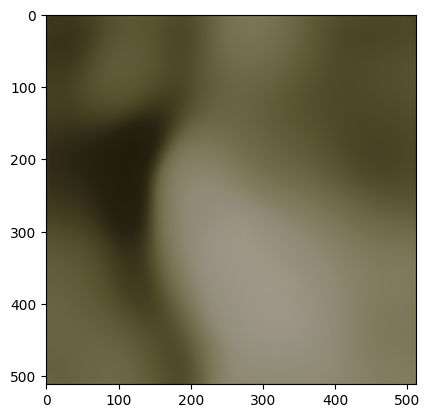

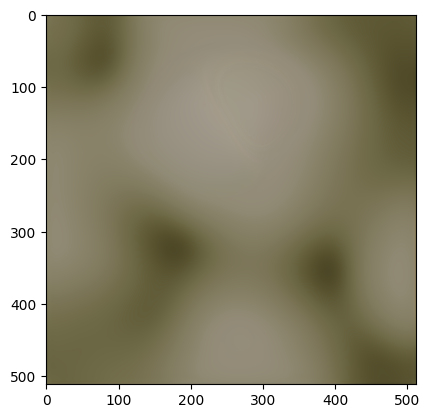

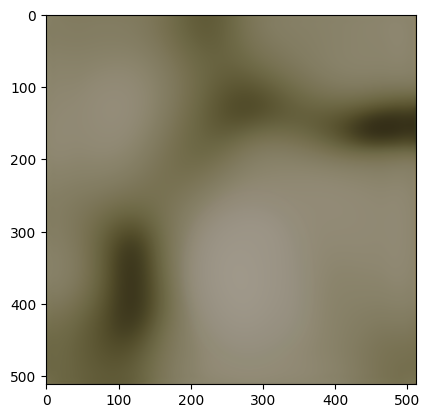

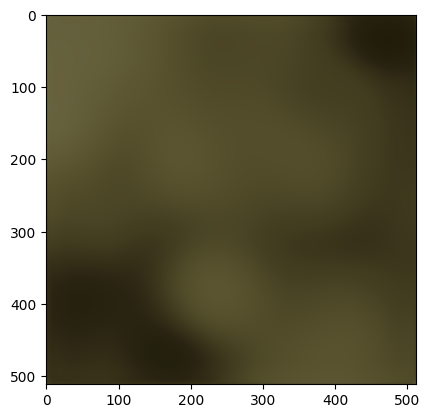

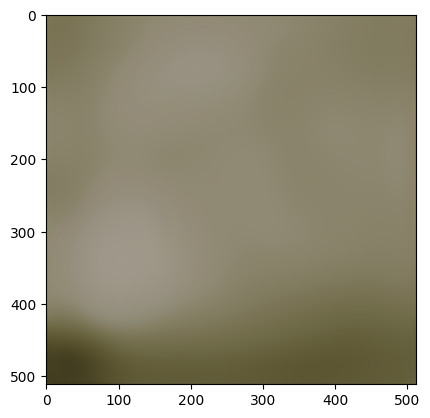

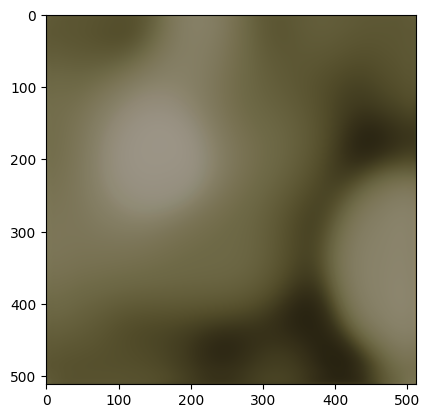

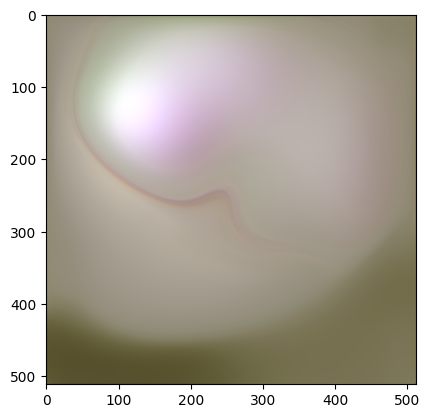

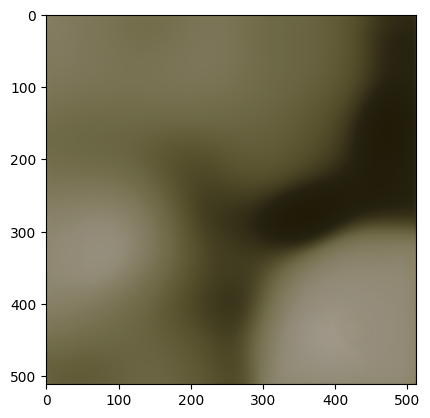

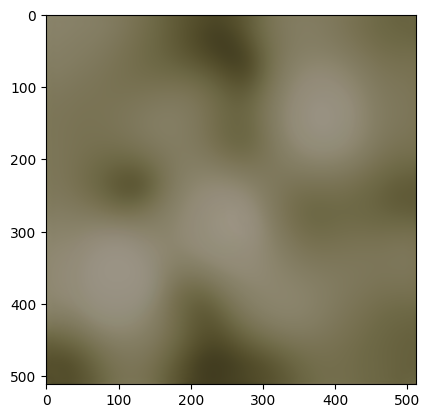

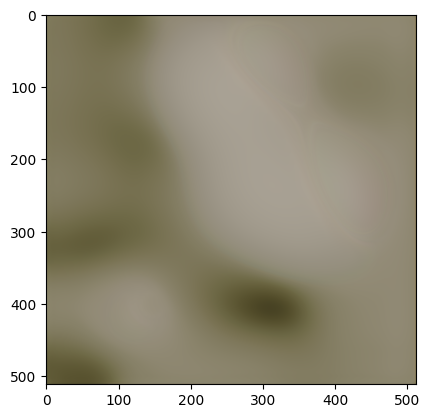

In [ ]:
# load few images of goods from dataloader and calculate losses for each test sample

good_losses = test(model, loss_fn, 'good')

In [ ]:
print(f"Loss on good: {sum(good_losses)/len(good_losses)}")

Loss on good: 0.1990098369241965


#### Testing on bads

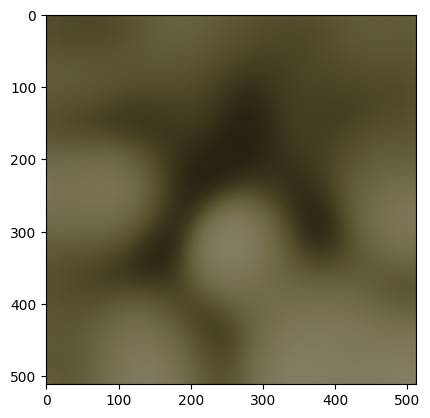

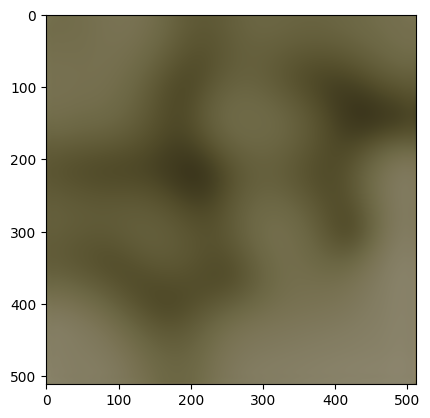

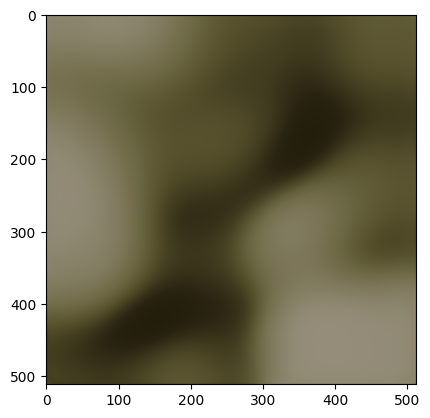

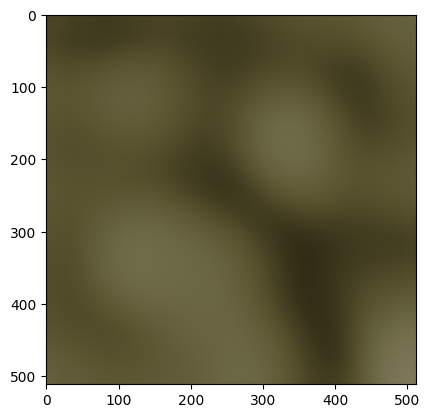

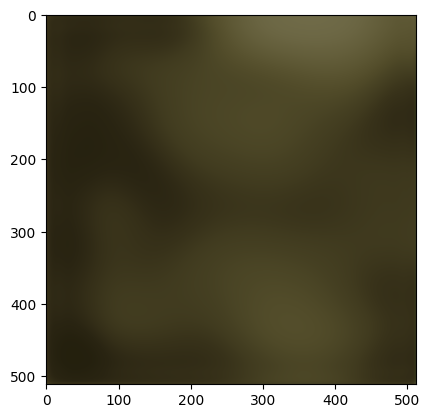

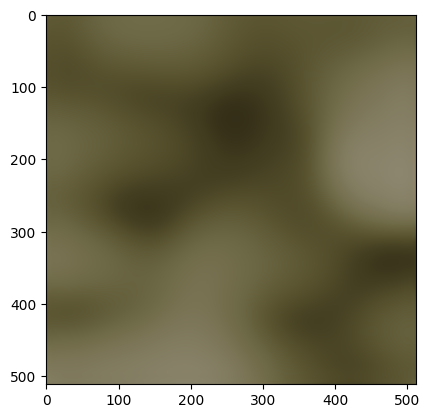

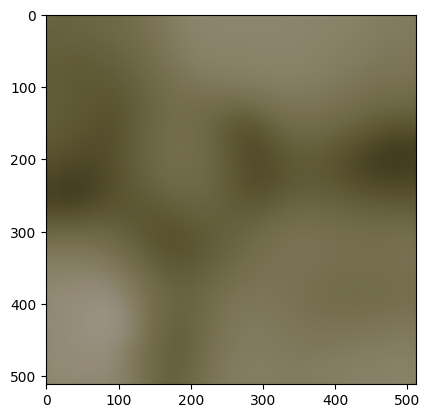

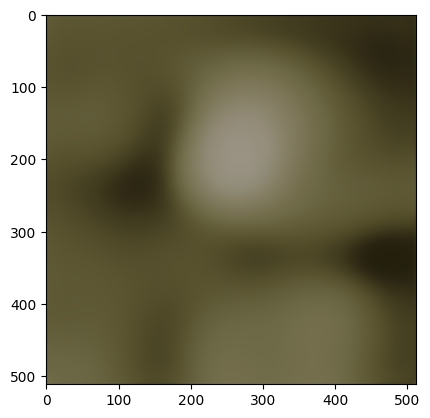

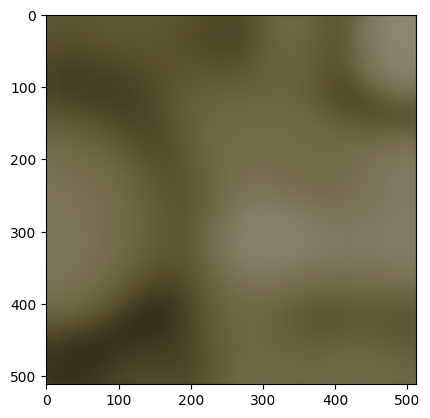

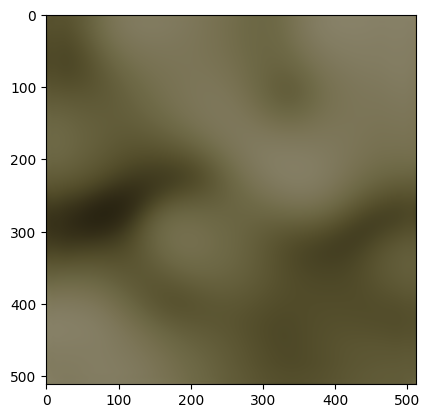

In [ ]:
# load few images of bads from dataloader and calculate losses for each test sample

bad_losses = test(model, loss_fn, 'bad')

In [ ]:
print(f"Loss on bad: {sum(bad_losses)/len(bad_losses)}")

Loss on bad: 0.3053411486641012


In [ ]:
### reset loaders
del train_loader, val_loader, test_good_loader, test_bad_loader, sp_transform, transform
torch.cuda.empty_cache()
gc.collect()

36359

#### Loss distribution

In [ ]:
#import pandas as pd

step = 0.005

# general
max_range = max(max(good_losses), max(bad_losses))
min_range = min(min(good_losses), min(bad_losses))
bins = np.arange(min_range, max_range, step)

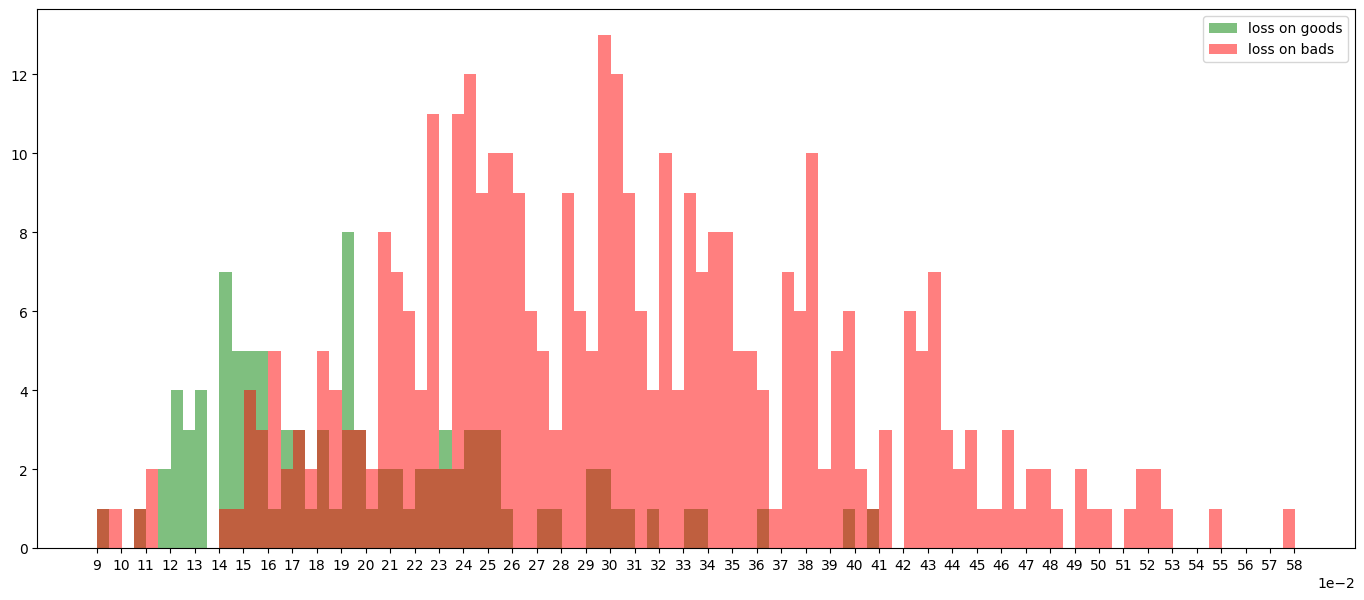

In [ ]:
plt.clf()
plt.gcf().set_size_inches(17, 7)
plt.xticks(np.round(np.arange(min_range, max_range, 0.01), 2))
plt.ticklabel_format(style='sci', axis='x', scilimits=(-2,-2))
plt.hist(good_losses, bins=bins, label='loss on goods', color='green', alpha=0.5)
plt.hist(bad_losses, bins=bins, label='loss on bads', color='red', alpha=0.5)

plt.legend(loc='best')
plt.show()

####Calculating confusion matrix

In [ ]:
# Avg loss on goods seems to be a good candidate for threshold
th = sum(good_losses)/len(good_losses)
step = 0.0005
ths = np.arange(
    th - 15 * 2 * step,
    th + 16 * 2 * step,
    step
)

In [ ]:
def calculatePerformance(threshold, loss_fn):

  TG = 0
  TB = 0
  FG = 0
  FB = 0

  rets = test(model, loss_fn, 'good', count_show=0)
  for loss in rets:

    if loss > threshold:
      FB += 1
    else:
      TG += 1

  rets = test(model, loss_fn, 'bad', count_show=0)
  for loss in rets:

    if loss > threshold:
      TB += 1
    else:
      FG += 1

  return TG, TB, FG, FB

In [ ]:
TG = None
TB = None
FG = None
FB = None
best_th = None

i = 1
for th in ths:

  print(f"Doing {i}/{len(ths)}")
  i += 1

  ### reset loaders

  g = torch.Generator()
  g.manual_seed(seed)
  tg = torch.Generator()
  tg.manual_seed(seed)
  pg = torch.Generator()
  pg.manual_seed(seed)

  sp_transform = SaltPepper(tg)

  tmp_g = torch.Generator()
  tmp_g.manual_seed(42424242)
  tg_test_state = tmp_g.get_state()

  transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((512, 512), antialias=True),
        sp_transform
    ]
  )

  train_loader, val_loader, test_good_loader, test_bad_loader = get_loaders(
        data_dir='drive/MyDrive/tesi/first_dataset',
        batch_size=batch_dimension,
        train_percentage=tr_prct,
        val_percentage=val_prct,
        transform=transform,
        num_workers=wrkrs,
        train_limit=limit,
  )

  tg.set_state(tg_test_state)

  tTG, tTB, tFG, tFB = calculatePerformance(th, loss_fn)

  if TG == None or (TG+TB)/(TG+TB+FG+FB) < (tTG+tTB)/(tTG+tTB+tFG+tFB):
    TG = tTG
    TB = tTB
    FG = tFG
    FB = tFB
    best_th = th
    print("########## NEW BEST")
    print(f"Threshold: {best_th}")
    print(f"Overall accuracy: {(TG+TB)/(TG+TB+FG+FB) * 100}%")
    print(f"True goods: {TG/(TG+FB) * 100}%")
    print(f"True bads: {TB/(TB+FG) * 100}%")
    print(f"False goods: {FG/(TB+FG) * 100}%")
    print(f"False bads: {(FB)/(TG+FB) * 100}%")
    print("####################")

  ### reset loaders

  del train_loader, val_loader, test_good_loader, test_bad_loader, sp_transform, transform
  torch.cuda.empty_cache()
  gc.collect()


print(f"Threshold: {best_th}")
print(f"Overall accuracy: {(TG+TB)/(TG+TB+FG+FB) * 100}%")
print(f"True goods: {TG/(TG+FB) * 100}%")
print(f"True bads: {TB/(TB+FG) * 100}%")
print(f"False goods: {FG/(TB+FG) * 100}%")
print(f"False bads: {(FB)/(TG+FB) * 100}%")

Doing 1/63
########## NEW BEST
Threshold: 0.18400983692419648
Overall accuracy: 82.62711864406779%
True goods: 47.474747474747474%
True bads: 91.95710455764075%
False goods: 8.04289544235925%
False bads: 52.52525252525253%
####################
Doing 2/63
Doing 3/63
Doing 4/63
Doing 5/63
Doing 6/63
Doing 7/63
Doing 8/63
Doing 9/63
Doing 10/63
Doing 11/63
Doing 12/63
Doing 13/63
Doing 14/63
Doing 15/63
Doing 16/63
Doing 17/63
Doing 18/63
Doing 19/63
Doing 20/63
Doing 21/63
########## NEW BEST
Threshold: 0.1940098369241965
Overall accuracy: 82.83898305084746%
True goods: 55.55555555555556%
True bads: 90.0804289544236%
False goods: 9.919571045576408%
False bads: 44.44444444444444%
####################
Doing 22/63
########## NEW BEST
Threshold: 0.1945098369241965
Overall accuracy: 83.05084745762711%
True goods: 56.56565656565656%
True bads: 90.0804289544236%
False goods: 9.919571045576408%
False bads: 43.43434343434344%
####################
Doing 23/63
Doing 24/63
Doing 25/63
Doing 26/63
Do

#### Save results

In [ ]:
with open(f"drive/MyDrive/tesi/saved_models/{genName()}/out_data.txt", "w+") as out:
  out.write(f"Threshold: {best_th}\n")
  out.write(f"Overall accuracy: {(TG+TB)/(TG+TB+FG+FB) * 100}%\n")
  out.write(f"True goods: {TG/(TG+FB) * 100}%\n")
  out.write(f"True bads: {TB/(TB+FG) * 100}%\n")
  out.write(f"False goods: {FG/(TB+FG) * 100}%\n")
  out.write(f"False bads: {(FB)/(TG+FB) * 100}%\n")

## Further performance test & maximization

### Manual treshold try

In [ ]:
g = torch.Generator()
g.manual_seed(seed)
tg = torch.Generator()
tg.manual_seed(seed)
pg = torch.Generator()
pg.manual_seed(seed)

sp_transform = SaltPepper(tg)

tmp_g = torch.Generator()
tmp_g.manual_seed(42424242)
tg_test_state = tmp_g.get_state()

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((512, 512), antialias=True),
        sp_transform
    ]
)

train_loader, val_loader, test_good_loader, test_bad_loader = get_loaders(
        data_dir='drive/MyDrive/tesi/first_dataset',
        batch_size=batch_dimension,
        train_percentage=tr_prct,
        val_percentage=val_prct,
        transform=transform,
        num_workers=wrkrs,
        train_limit=limit,
)

In [ ]:
th = sum(good_losses)/len(good_losses)

In [ ]:
tg.set_state(tg_test_state)

In [ ]:
TG, TB, FG, FB = calculatePerformance(th, loss_fn)
print(f"Threshold: {th}")
print(f"Overall accuracy: {(TG+TB)/(TG+TB+FG+FB) * 100}%")
print(f"True goods: {TG/(TG+FB) * 100}%")
print(f"True bads: {TB/(TB+FG) * 100}%")
print(f"False goods: {FG/(TB+FG) * 100}%")
print(f"False bads: {(FB)/(TG+FB) * 100}%")

In [ ]:
### reset loaders
del train_loader, val_loader, test_good_loader, test_bad_loader, sp_transform, transform
torch.cuda.empty_cache()
gc.collect()

### F0.5 - F1 - F2 scores maximization

In [ ]:
def f_score(tp, fp, fn, b):
  return (1 + b**2) * (tp / ((1 + b**2)*tp + b*b*fn + fp))

In [ ]:
best_th_f1 = None
best_th_f05 = None
best_th_f2 = None
best_f1 = None
best_f05 = None
best_f2 = None
f1_vals = []
f2_vals = []
f05_vals = []

i = 1
for th in ths:

  print(f"Doing {i}/{len(ths)}")
  i += 1

  ### reset loaders

  g = torch.Generator()
  g.manual_seed(seed)
  tg = torch.Generator()
  tg.manual_seed(seed)

  sp_transform = SaltPepper(tg)

  tmp_g = torch.Generator()
  tmp_g.manual_seed(42424242)
  tg_test_state = tmp_g.get_state()

  transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((512, 512), antialias=True),
        sp_transform
    ]
  )

  train_loader, val_loader, test_good_loader, test_bad_loader = get_loaders(
        data_dir='drive/MyDrive/tesi/first_dataset',
        batch_size=batch_dimension,
        train_percentage=tr_prct,
        val_percentage=val_prct,
        transform=transform,
        num_workers=wrkrs,
        train_limit=limit,
  )

  tg.set_state(tg_test_state)

  TG, TB, FG, FB = calculatePerformance(th, loss_fn)
  f1 = f_score(TB, FB, FG, 1)
  f05 = f_score(TB, FB, FG, 0.5)
  f2 = f_score(TB, FB, FG, 2)

  if best_f1 == None or best_f1 < f1:
    best_f1 = f1
    best_th_f1 = th
    f1_vals = [TG, TB, FG, FB]
    print("########## NEW BEST F1")
    print(f"Threshold: {th}")
    print(f"F1 Score: {f1}")
    print("####################")
  if best_f2 == None or best_f2 < f2:
    best_f2 = f2
    best_th_f2 = th
    f2_vals = [TG, TB, FG, FB]
    print("########## NEW BEST F2")
    print(f"Threshold: {th}")
    print(f"F2 Score: {f2}")
    print("####################")
  if best_f05 == None or best_f05 < f05:
    best_f05 = f05
    best_th_f05 = th
    f05_vals = [TG, TB, FG, FB]
    print("########## NEW BEST F0.5")
    print(f"Threshold: {th}")
    print(f"F05 Score: {f05}")
    print("####################")


  ### reset loaders

  del train_loader, val_loader, test_good_loader, test_bad_loader, sp_transform, transform
  torch.cuda.empty_cache()
  gc.collect()



print("")
print("#################### BEST RESULTS")
print(f"Threshold: {best_th_f1}")
print(f"F1 Score: {best_f1}")
print("---")
print(f"Threshold: {best_th_f2}")
print(f"F2 Score: {best_f2}")
print("---")
print(f"Threshold: {best_th_f05}")
print(f"F05 Score: {best_f05}")

Doing 1/63
########## NEW BEST F1
Threshold: 0.18400983692419648
F1 Score: 0.8932291666666666
####################
########## NEW BEST F2
Threshold: 0.18400983692419648
F2 Score: 0.9088500264970854
####################
########## NEW BEST F0.5
Threshold: 0.18400983692419648
F05 Score: 0.8781362007168458
####################
Doing 2/63
Doing 3/63
########## NEW BEST F0.5
Threshold: 0.18500983692419648
F05 Score: 0.8791773778920309
####################
Doing 4/63
Doing 5/63
Doing 6/63
Doing 7/63
Doing 8/63
########## NEW BEST F0.5
Threshold: 0.18750983692419648
F05 Score: 0.8794619762027935
####################
Doing 9/63
Doing 10/63
Doing 11/63
Doing 12/63
Doing 13/63
Doing 14/63
Doing 15/63
########## NEW BEST F0.5
Threshold: 0.19100983692419649
F05 Score: 0.8826610790990047
####################
Doing 16/63
Doing 17/63
########## NEW BEST F0.5
Threshold: 0.1920098369241965
F05 Score: 0.8837453971593898
####################
Doing 18/63
Doing 19/63
########## NEW BEST F0.5
Threshold: 0.1

In [ ]:
print("Insights of detailed performances of Fb scores")

TG, TB, FG, FB = f1_vals
print("################ F1 score")
print(f"Threshold: {best_th_f1}")
print(f"F1 Score: {best_f1}")
print(f"Overall accuracy: {(TG+TB)/(TG+TB+FG+FB) * 100}%")
print(f"True goods: {TG/(TG+FB) * 100}%")
print(f"True bads: {TB/(TB+FG) * 100}%")
print(f"False goods: {FG/(TB+FG) * 100}%")
print(f"False bads: {(FB)/(TG+FB) * 100}%")

print("")
print("")

TG, TB, FG, FB = f2_vals
print("################ F2 score")
print(f"Threshold: {best_th_f2}")
print(f"F2 Score: {best_f2}")
print(f"Overall accuracy: {(TG+TB)/(TG+TB+FG+FB) * 100}%")
print(f"True goods: {TG/(TG+FB) * 100}%")
print(f"True bads: {TB/(TB+FG) * 100}%")
print(f"False goods: {FG/(TB+FG) * 100}%")
print(f"False bads: {(FB)/(TG+FB) * 100}%")

print("")
print("")

TG, TB, FG, FB = f05_vals
print("################ F05 score")
print(f"Threshold: {best_th_f05}")
print(f"F05 Score: {best_f05}")
print(f"Overall accuracy: {(TG+TB)/(TG+TB+FG+FB) * 100}%")
print(f"True goods: {TG/(TG+FB) * 100}%")
print(f"True bads: {TB/(TB+FG) * 100}%")
print(f"False goods: {FG/(TB+FG) * 100}%")
print(f"False bads: {(FB)/(TG+FB) * 100}%")

Insights of detailed performances of Fb scores
################ F1 score
Threshold: 0.2020098369241965
F1 Score: 0.8936742934051144
Overall accuracy: 83.26271186440678%
True goods: 61.61616161616161%
True bads: 89.00804289544236%
False goods: 10.991957104557642%
False bads: 38.38383838383838%


################ F2 score
Threshold: 0.18400983692419648
F2 Score: 0.9088500264970854
Overall accuracy: 82.62711864406779%
True goods: 47.474747474747474%
True bads: 91.95710455764075%
False goods: 8.04289544235925%
False bads: 52.52525252525253%


################ F05 score
Threshold: 0.2020098369241965
F05 Score: 0.8958445763626552
Overall accuracy: 83.26271186440678%
True goods: 61.61616161616161%
True bads: 89.00804289544236%
False goods: 10.991957104557642%
False bads: 38.38383838383838%


### Save results

In [ ]:
with open(f"drive/MyDrive/tesi/saved_models/{genName()}/f_scores.txt", "w+") as out:
  TG, TB, FG, FB = f1_vals
  out.write("################ F1 score\n")
  out.write(f"Threshold: {best_th_f1}\n")
  out.write(f"F1 Score: {best_f1}\n")
  out.write(f"Overall accuracy: {(TG+TB)/(TG+TB+FG+FB) * 100}%\n")
  out.write(f"True goods: {TG/(TG+FB) * 100}%\n")
  out.write(f"True bads: {TB/(TB+FG) * 100}%\n")
  out.write(f"False goods: {FG/(TB+FG) * 100}%\n")
  out.write(f"False bads: {(FB)/(TG+FB) * 100}%\n")

  out.write("\n")
  out.write("\n")

  TG, TB, FG, FB = f2_vals
  out.write("################ F2 score\n")
  out.write(f"Threshold: {best_th_f2}\n")
  out.write(f"F2 Score: {best_f2}\n")
  out.write(f"Overall accuracy: {(TG+TB)/(TG+TB+FG+FB) * 100}%\n")
  out.write(f"True goods: {TG/(TG+FB) * 100}%\n")
  out.write(f"True bads: {TB/(TB+FG) * 100}%\n")
  out.write(f"False goods: {FG/(TB+FG) * 100}%\n")
  out.write(f"False bads: {(FB)/(TG+FB) * 100}%\n")

  out.write("\n")
  out.write("\n")

  TG, TB, FG, FB = f05_vals
  out.write("################ F05 score\n")
  out.write(f"Threshold: {best_th_f05}\n")
  out.write(f"F05 Score: {best_f05}\n")
  out.write(f"Overall accuracy: {(TG+TB)/(TG+TB+FG+FB) * 100}%\n")
  out.write(f"True goods: {TG/(TG+FB) * 100}%\n")
  out.write(f"True bads: {TB/(TB+FG) * 100}%\n")
  out.write(f"False goods: {FG/(TB+FG) * 100}%\n")
  out.write(f"False bads: {(FB)/(TG+FB) * 100}%\n")

### ROC-AUC

In [ ]:
### reset loaders

g = torch.Generator()
g.manual_seed(seed)
tg = torch.Generator()
tg.manual_seed(seed)
pg = torch.Generator()
pg.manual_seed(seed)

sp_transform = SaltPepper(tg)

tmp_g = torch.Generator()
tmp_g.manual_seed(42424242)
tg_test_state = tmp_g.get_state()

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((512, 512), antialias=True),
        sp_transform
    ]
)

train_loader, val_loader, test_good_loader, test_bad_loader = get_loaders(
        data_dir='drive/MyDrive/tesi/first_dataset',
        batch_size=batch_dimension,
        train_percentage=tr_prct,
        val_percentage=val_prct,
        transform=transform,
        num_workers=wrkrs,
        train_limit=500,
)

In [ ]:
tg.set_state(tg_test_state)

In [ ]:
yg_preds = test(model, loss_fn, 'good', count_show=0)
yb_preds = test(model, loss_fn, 'bad', count_show=0)

In [ ]:
### reset loaders

del train_loader, val_loader, test_good_loader, test_bad_loader, sp_transform, transform
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
y_preds = yg_preds + yb_preds
y_true = [0 for _ in yg_preds] + [1 for _ in yb_preds]

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_preds)

### Display ROC curve and calculate ROC-AUC score

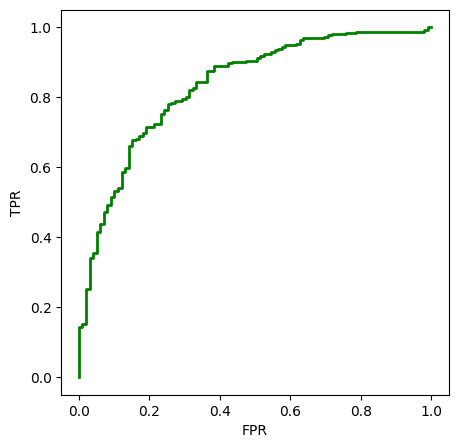

In [ ]:
plt.clf()
plt.gcf().set_size_inches(5, 5)
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.plot(fpr, tpr, color='green', linewidth=2)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

In [ ]:
metrics.auc(fpr, tpr)

0.83467381590706

In [ ]:
with open(f"drive/MyDrive/tesi/saved_models/{genName()}/roc-auc-score.txt", "w+") as out:
  out.write(f"{metrics.auc(fpr, tpr)}")